In [1]:
from src.util import DataLoader, AortaNormalizer
from src.visualiazation import plot_pca, plot_random_predictions, plot_relative_error_aorta
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

**Load Data**

In [2]:
data_path = "../../../data/PulHypStudie_Check_npz_v2/"

In [3]:
data_list = [i for i in range(1, 10)]
data_list # pig 10 -> test pig

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
data_loader = DataLoader(data_path)

X, Y, Pig = data_loader.load_data(data_list)

Data path: ../../../data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
Got a list of 9 pigs to load.
To load ['P_01_PulHyp' 'P_02_PulHyp' 'P_03_PulHyp' 'P_04_PulHyp' 'P_05_PulHyp'
 'P_06_PulHyp' 'P_07_PulHyp' 'P_08_PulHyp' 'P_09_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_01_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_02_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_03_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_04_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_05_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_06_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_07_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_08_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_09_

In [5]:
aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

**Load VAE**

In [8]:
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    Conv1D,
    ZeroPadding1D,
    Reshape,
    Cropping1D,
)
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss, reconstruction_loss, kl_loss = self.vae_loss(
                data, reconstruction, z_mean, z_log_var
            )

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        loss, reconstruction_loss, kl_loss = self.vae_loss(
            data, reconstruction, z_mean, z_log_var
        )

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        mse_loss_fn = MeanSquaredError()
        input_dim = 1024
        reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss


# The encoder model
def encoder_model(
    input_shape=(1024, 1),
    channels=(5, 10, 20, 30),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
    latent_dim=8,
):
    encoder_inputs = Input(shape=input_shape)
    x = encoder_inputs

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


# The decoder model
def decoder_model(
    latent_dim=8,
    channels=(30, 20, 10, 5),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
):
    latent_inputs = Input(shape=(latent_dim,))
    L = (1024 // np.prod(strides)) * channels[0]
    x = Dense(L, activation="elu")(latent_inputs)
    x = Reshape((1024 // np.prod(strides), channels[0]))(x)

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1DTranspose(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Conv1DTranspose(1, 1, activation="elu", padding="same")(x)
    decoded = x

    return latent_inputs, decoded
    
def build_vae_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=4, max_value=16, step=4)
    beta = hp.Float("beta", min_value=0.1, max_value=2.0, step=0.1)
    #num_channels_choice = hp.Choice("num_channels", values=[5, 10, 20, 30])
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=9, step=1)  
    strides = hp.Int("strides", min_value=2, max_value=4, step=1)
        
    channels=(5, 10, 20, 30)
    # kernel_sizes=(5, 5, 5, 5)
    kernel_sizes = [kernel_size] * 4
    # strides=(4, 4, 4, 4)
    stride_sizes = [strides] * 4

    # Build encoder and decoder
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        channels=channels,
        kernel_size=kernel_sizes,
        strides=stride_sizes,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="Encoder")
    
    decoder_inputs, decoder_outputs = decoder_model(
        channels=channels[::-1],
        kernel_size=kernel_sizes[::-1],
        strides=stride_sizes[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="Decoder")

    encoder.summary()
    decoder.summary()
    vae = VAE(encoder, decoder, beta=beta)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5])))
    return vae

# Instantiate the tuner
tuner = kt.Hyperband(
    build_vae_model,
    objective="loss",
    max_epochs=20,
    factor=2,
    directory="vae_hpt",
    project_name="vae_tuning_1",
)

Reloading Tuner from vae_hpt/vae_tuning_1/tuner0.json


In [9]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [11]:
vae = tuner.hypermodel.build(best_hps)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1024, 5)   │         20 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 5)   │         20 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 256, 5)    │         80 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 5)    │         20 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 256, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 256, 10)   │        160 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 10)   │         40 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 64, 10)    │        310 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 10)    │         40 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 64, 10)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 64, 20)    │        620 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 20)    │         80 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 20)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 16, 20)    │      1,220 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 20)    │         80 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 16, 20)    │          0 │ batch_normalizat

 Total params: 9,426 (36.82 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 16, 30)         │         2,730 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 16, 30)         │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 64, 20)         │         1,820 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 64, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 256, 10)        │           610 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 256, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 256, 10)        │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,261 (43.99 KB)

 Trainable params: 11,001 (42.97 KB)

 Non-trainable params: 260 (1.02 KB)

In [12]:
# sel_model = "src/weights/vae_model_excl10_0.weights.h5"
# sel_model = "src/weights/vae_model_excl_none_1.weights.h5"
sel_model = "src/weights/vae_model_excl_10_2.weights.h5"

#vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.load_weights(sel_model)
_,_,z = vae.encoder.predict(Y_norm)

I0000 00:00:1732722466.217306 2959076 service.cc:145] XLA service 0x702a0800dbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732722466.217383 2959076 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-11-27 16:47:46.250490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-27 16:47:48.260628: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  93/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

I0000 00:00:1732722469.136638 2959076 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2298/2298 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


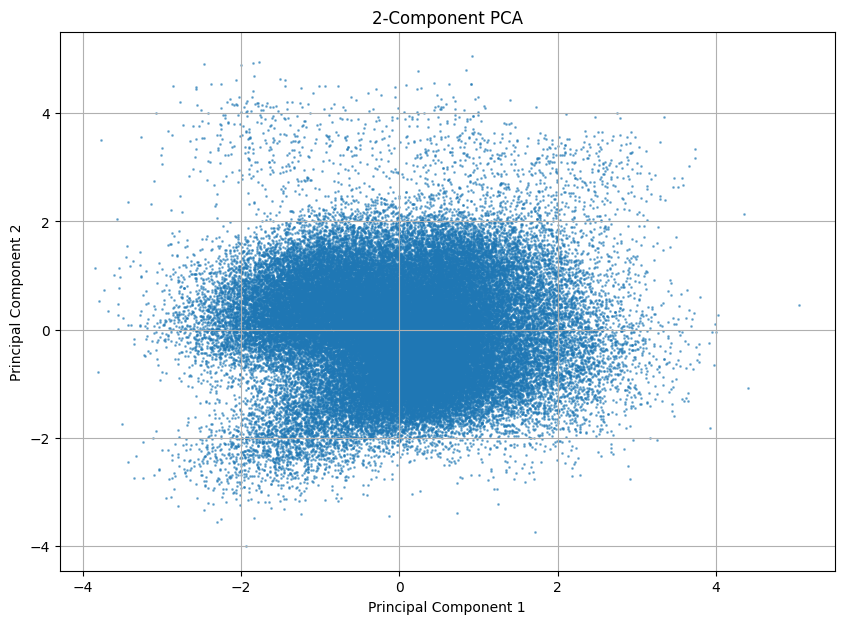

In [13]:
plot_pca(z)

**Train Mapper**

- [KerasTuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [14]:
import keras_tuner as kt
from tensorflow import keras

_HPT with MeanAbsoluteError_

In [19]:
def build_model(hp):
    latent_dim = 8
    # initialize the sequential model.
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(latent_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    
    return model

In [20]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hpt_mapper_n',
    project_name='hpt_mapper_none_exlude'
)


Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 512, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64, 512, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 256, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 128, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 128, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       131,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,150 (512.30 KB)

 Trainable params: 131,138 (512.26 KB)

 Non-trainable params: 12 (48.00 B)

None


In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(X, z, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 2 Complete [00h 01m 02s]
val_accuracy: 0.27359259128570557

Best val_accuracy So Far: 0.27359259128570557
Total elapsed time: 00h 01m 57s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
7                 |7                 |num_layers
2                 |2                 |units_1
3                 |8                 |kernel_1
2                 |1                 |units_0_1
4                 |2                 |units_1_1
relu              |tanh              |activation_1
0.9               |0.4               |dropout_1
14                |14                |units_2
6                 |4                 |kernel_2
4                 |2                 |units_0_2
2                 |4                 |units_1_2
elu               |relu              |activation_2
0.3               |0.6               |dropout_2
10                |10                |units_3
2                 |7                 |kernel_3
3                 |4                 |units_0_3
4         

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 256, 2)     │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 128, 14)     │         1,022 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 128, 14)     │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 128, 14)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128, 14)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 32, 10)      │           570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 32, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 32, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 32, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 16, 14)      │         2,254 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 16, 14)      │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 16, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 16, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 4, 14)       │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 4, 14)       │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 4, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 4, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 2, 14)       │        12,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 2, 14)       │            56 │
│ (BatchNormalization)            │                        │             

 Total params: 20,078 (78.43 KB)

 Trainable params: 19,942 (77.90 KB)

 Non-trainable params: 136 (544.00 B)

None
Epoch 1/2
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1274 - loss: 0.8939

In [23]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [24]:
best_hps.values

{'num_layers': 4,
 'units_1': 6,
 'kernel_1': 9,
 'units_0_1': 3,
 'units_1_1': 3,
 'activation_1': 'relu',
 'dropout_1': 0.2,
 'units_2': 10,
 'kernel_2': 6,
 'units_0_2': 1,
 'units_1_2': 4,
 'activation_2': 'elu',
 'dropout_2': 0.5,
 'units_3': 10,
 'kernel_3': 8,
 'units_0_3': 2,
 'units_1_3': 3,
 'activation_3': 'tanh',
 'dropout_3': 0.1,
 'learning_rate': 0.001,
 'units_4': 14,
 'kernel_4': 5,
 'units_0_4': 3,
 'units_1_4': 2,
 'activation_4': 'tanh',
 'dropout_4': 0.1,
 'units_5': 6,
 'kernel_5': 7,
 'units_0_5': 3,
 'units_1_5': 3,
 'activation_5': 'elu',
 'dropout_5': 0.9,
 'units_6': 10,
 'kernel_6': 9,
 'units_0_6': 3,
 'units_1_6': 3,
 'activation_6': 'elu',
 'dropout_6': 0.7000000000000001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

**Load Best Model**

In [25]:
model = tuner.hypermodel.build(best_hps)

Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 22, 342, 6)     │           492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 342, 6)     │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 342, 6)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 342, 6)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 86, 10)     │         2,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 86, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 22, 86, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 86, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 29, 10)     │         6,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 29, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 29, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3190)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        25,528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,704 (135.56 KB)

 Trainable params: 34,652 (135.36 KB)

 Non-trainable params: 52 (208.00 B)

None


In [26]:
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(
    X,
    z,
    epochs=100,
    batch_size=16,
    # callbacks=[es],
    validation_split=0.2,
)

Epoch 1/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.3070 - loss: 0.7597 - val_accuracy: 0.4819 - val_loss: 0.5776
Epoch 2/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4679 - loss: 0.5886 - val_accuracy: 0.4926 - val_loss: 0.5567
Epoch 3/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4815 - loss: 0.5747 - val_accuracy: 0.4946 - val_loss: 0.5490
Epoch 4/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4847 - loss: 0.5660 - val_accuracy: 0.4999 - val_loss: 0.5432
Epoch 5/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4923 - loss: 0.5623 - val_accuracy: 0.5058 - val_loss: 0.5425
Epoch 6/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4914 - loss: 0.5585 - val_accuracy: 0.5013 - val_loss: 0.5357
Epoch 7/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4883 - loss: 0.5557 - val_accuracy: 0.5041 - val_loss: 0.5366
Epoch 8/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4982 -

In [28]:
model.save_weights("src/weights/mapper_model_4.weights.h5")
np.savez("src/weights/mapper_model_4_history.npz", history=history)

**Test model**

In [29]:
X_test, Y_t, _ = data_loader.load_data(10)

aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y_t)
Y_true = Y_t[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

To load ['P_10_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_10_PulHyp

Aorta curve min=45.03, max=139.87
Eit.shape=(6282, 64, 1024, 1), Y.shape=(6282, 1024, 1)


In [30]:
# predict with trained model
z_pred = model.predict(X_test)
Y_pred = vae.decoder.predict(z_pred)
Y_pred = aorta_normalizer.normalize_inverse(Y_pred)[:,:,0]

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


Pearson correlation coefficient mean 0.9653842790816871
MAE 975775.2366847275
MSE 61732.715947757955
Pearson number 0.9653842790816871


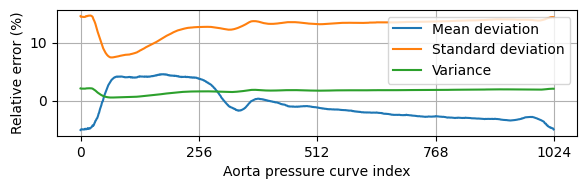

(61732.715947757955, 975775.2366847275, 0.9653842790816871)

In [34]:
rel_err_config = {
    "std" : True,
    "var" : True,
    "mean" : True,
    "s_name" : "serious_result_1.png",
}

plot_relative_error_aorta(Y_true,Y_pred,**rel_err_config)

Selected prediction 2998.


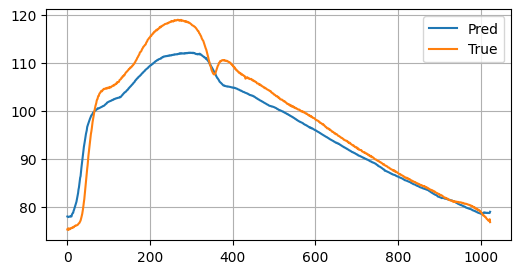

Selected prediction 5774.


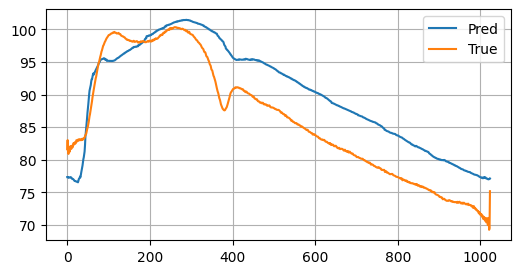

Selected prediction 868.


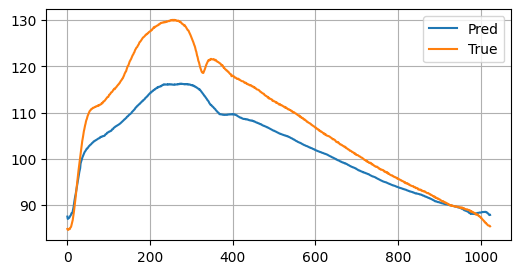

Selected prediction 904.


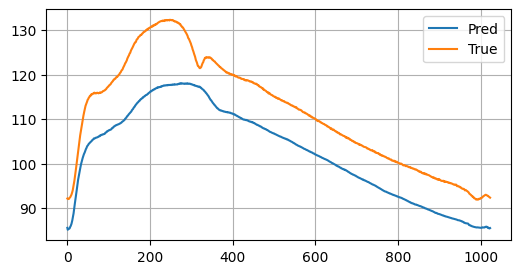

Selected prediction 4703.


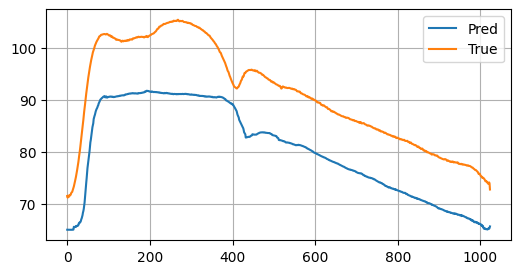

Selected prediction 6118.


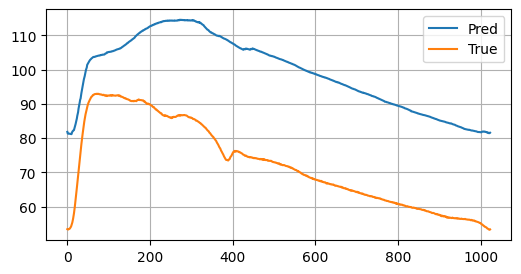

Selected prediction 3524.


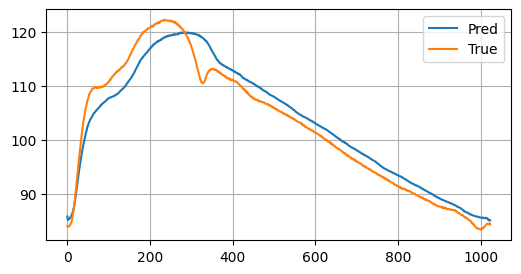

Selected prediction 440.


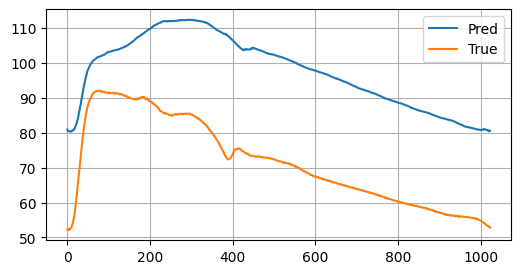

Selected prediction 374.


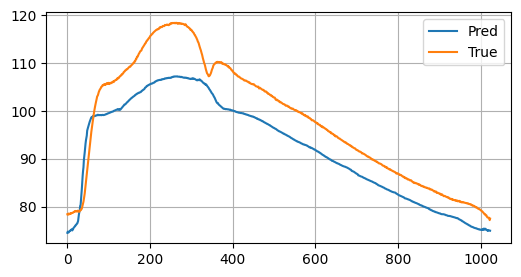

Selected prediction 4033.


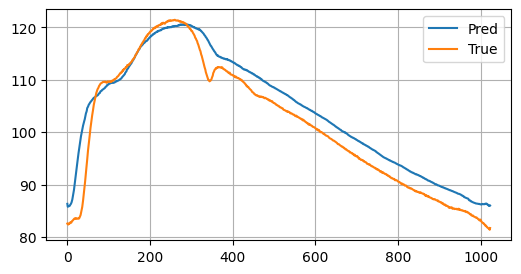

In [38]:
plot_random_predictions(Y_true,Y_pred,n=10)

In [39]:
from src.LaTeX_export import output_err_for_LaTeX,output_curve_for_LaTeX

In [42]:
output_err_for_LaTeX(Y_true, Y_pred,f_name = "err_serious_result_1.csv")

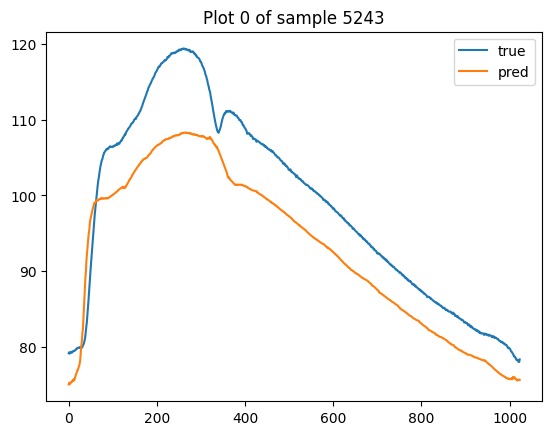

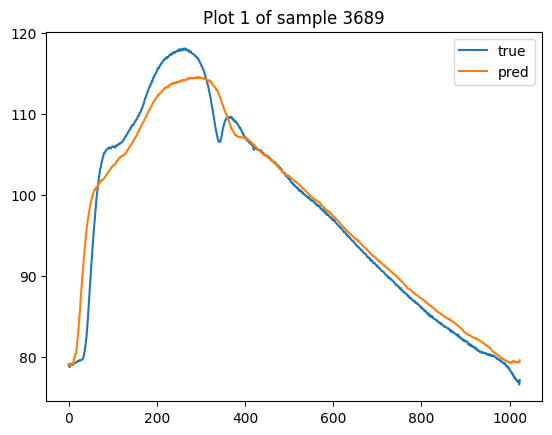

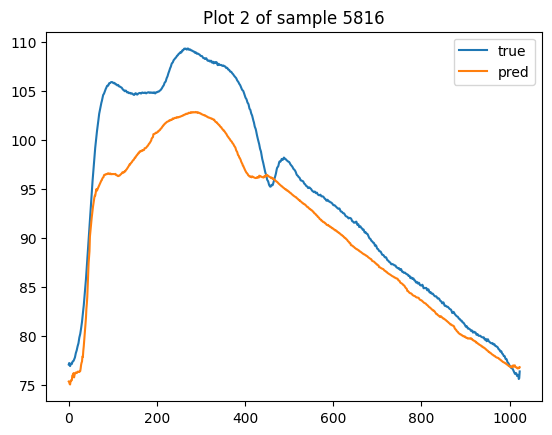

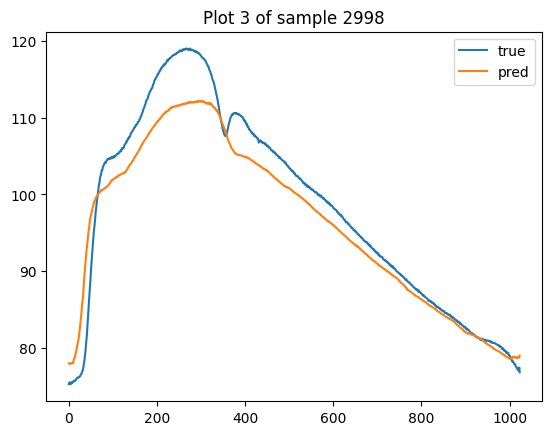

In [51]:
output_curve_for_LaTeX(Y_true, Y_pred,f_name = "curve_serious_result_1.csv")

In [67]:
Y_true.shape

(6282, 1024)

In [71]:
np.mean(np.abs(Y_true-Y_pred))

10.213764742638709

**Archive**

*Train Mapper*